In [1]:
import qml
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import alchemy_tools as alch
import qml_interface as qi

### Plots

In [15]:
at_ae = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/mic/lcurve_atomisation_atomic.txt')
at_ae_sum = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/mic/lcurve_atomisation_molecule.txt')
mol_ae_global = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/reference/l_curve_global_global.tab')
mol_ae_local = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/reference/l_curve_local_rep_global_label.tab')

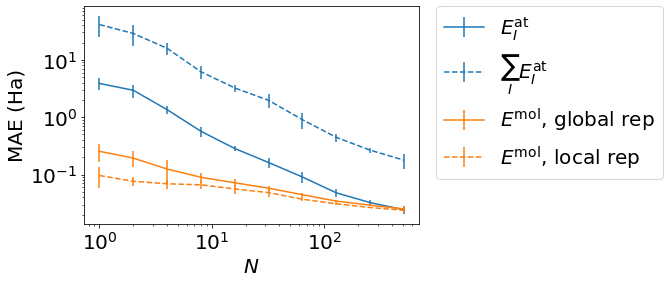

In [30]:
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(1,1)

ax.errorbar(at_ae[:,0], at_ae[:,1], at_ae[:,2], color = 'tab:blue', label = r'$E_I^{\rm{at}}$')
ax.errorbar(at_ae_sum[:,0], at_ae_sum[:,1], at_ae_sum[:,2], ls='--', color = 'tab:blue', label = r'$\sum_I E_I^{\rm{at}}$')
ax.errorbar(mol_ae_global[:,0], mol_ae_global[:,1], mol_ae_global[:,2], color = 'tab:orange', label = r'$E^{\rm{mol}}$, global rep')
ax.errorbar(mol_ae_local[:,0], mol_ae_local[:,1], mol_ae_local[:,2], ls='--',color = 'tab:orange', label = r'$E^{\rm{mol}}$, local rep')

ax.set_xlabel(r'$N$')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

directory = '/home/misa/projects/Atomic-Energies/figures/machine_learning/learning_curves/'
plt.savefig(directory+'lcurve_atomic_energy_vs_molecular_energy.png', bbox_inches = 'tight')

# Import data

In [2]:
paths=qi.wrapper_alch_data()
# load data into list, count number of atoms per molecule
alchemy_data, molecule_size = qi.load_alchemy_data(paths)

# Select training and validation set

In [53]:
training_set_size = 512
global_idc = qi.get_indices(len(alchemy_data), training_set_size)
local_idc = qi.get_local_idx(global_idc[0], molecule_size), qi.get_local_idx(global_idc[1], molecule_size)

# Global Model

In [54]:
global_reps = qi.wrapper_global_representations(alchemy_data, molecule_size) # all global representations

global_labels = np.zeros(len(global_reps)) # all global labels
for idx, mol in enumerate(alchemy_data):
    global_labels[idx] = alchemy_data[idx][:,6].sum()

In [55]:
# Optimization
gl_reps_tr = global_reps[global_idc[0]] # representations
gl_reps_val = global_reps[global_idc[1]]

gl_labs_tr = global_labels[global_idc[0]] # labels
gl_labs_val = global_labels[global_idc[1]]

sigmas = np.logspace(-1, 4, 12) # hyperparameter
lams = np.logspace(-15, 0, 16)

gl_opt = qi.optimize_hypar((gl_reps_tr, gl_reps_val), (gl_labs_tr, gl_labs_val), sigmas, lams )


In [56]:
idx_opt = np.where(gl_opt[0][:,2]==np.amin(gl_opt[0][:,2]) )
gl_opt[0][idx_opt]

array([[4.32876128e+02, 1.00000000e-06, 2.54011603e-02]])

In [57]:
gl_opt[2].mean()

0.02540116028513328

# Generate labels

In [58]:
global_labels = np.zeros(len(alchemy_data))
for idx, mol in enumerate(alchemy_data):
    global_labels[idx] = alchemy_data[idx][:,6].sum()
    
local_labels = qi.generate_label_vector(alchemy_data, molecule_size.sum())

# Select training and test set

In [13]:
training_set_size = 400
global_idc = qi.get_indices(len(global_reps), training_set_size)
local_idc = qi.get_local_idx(global_idc[0], molecule_size), qi.get_local_idx(global_idc[1], molecule_size)

In [14]:
len(local_idc[0])

5403

# Predictions

In [15]:
# global
pred,tr=qi.test(global_reps, global_idc[0], global_idc[1], global_labels, 70, 1e-10)
pred[1]

0.031565410971827745

In [16]:
# train and test local kernel
local_sigma = 278.2559402207126
local_lambda = 1e-8
coeffs = qi.train_kernel(local_reps, local_idc[0], local_labels, local_sigma, local_lambda)
test_kernel = qml.kernels.gaussian_kernel(local_reps[local_idc[1]], local_reps[local_idc[0]], local_sigma)
local_pred = np.dot(test_kernel, coeffs)

NameError: name 'local_reps' is not defined

In [13]:
# local: average error per atom
err_atom = np.abs(local_pred - local_labels[local_idc[1]]).mean()
err_atom

0.062429233755284225

In [14]:
np.abs(local_pred - local_labels[local_idc[1]])

array([0.2396297 , 0.17921321, 1.15942151, ..., 0.03772702, 0.05933936,
       0.25829823])

In [15]:
# train and test local kernel
for s in np.logspace(2, 4, 10):
    local_sigma = s
    local_lambda = 1e-8
    coeffs = qi.train_kernel(local_reps, local_idc[0], local_labels, local_sigma, local_lambda)
    test_kernel = qml.kernels.gaussian_kernel(local_reps[local_idc[1]], local_reps[local_idc[0]], local_sigma)
    local_pred = np.dot(test_kernel, coeffs)
    err_atom = np.abs(local_pred - local_labels[local_idc[1]]).mean()
    print('sigma = {}, error = {}'.format(s, err_atom))

sigma = 100.0, error = 0.1347183068451219
sigma = 166.81005372000593, error = 0.07422798631823654
sigma = 278.2559402207126, error = 0.062429233755284225
sigma = 464.15888336127773, error = 0.06337876391970347
sigma = 774.263682681127, error = 0.06538078246263897
sigma = 1291.549665014884, error = 0.06723602863631163
sigma = 2154.4346900318824, error = 0.06952301099459512
sigma = 3593.813663804626, error = 0.07642523818787635
sigma = 5994.8425031894085, error = 0.08822980693055098
sigma = 10000.0, error = 0.11103506099189916


In [16]:
# local: average error per element

# nuclear charge of atoms in test set
nuc_charges = np.power(local_reps[local_idc[1]]*2, 1/2.4)[:,0].astype(int)
tmp = np.array([nuc_charges, np.abs(local_pred - local_labels[local_idc[1]])])
err_h = tmp[1][np.where(tmp[0]==1)].mean()
err_c = tmp[1][np.where(tmp[0]==6)].mean()
err_n = tmp[1][np.where(tmp[0]==7)].mean()
err_o = tmp[1][np.where(tmp[0]==8)].mean()

In [17]:
print('Error H = %f' % err_h)
print('Error C = %f' % err_c)
print('Error N = %f' % err_n)
print('Error O = %f' % err_o)

Error H = 0.110701
Error C = 0.102225
Error N = 0.124877
Error O = 0.136253


In [18]:
# local: average error per molecule
loc_ae = np.empty(len(global_idc[1]))
start = 0
for i,gl in enumerate(global_idc[1]):
    length = molecule_size[gl]
    loc_ae[i] = local_pred[start:start+length].sum()
    start += length
err_mol = (np.abs(loc_ae-global_labels[global_idc[1]])).mean()
err_mol

0.7326610419096422

In [19]:
nuc_charges = np.power(local_reps*2, 1/2.4)[:,0].astype(int)
# tmp = np.array([nuc_charges, local_reps])
h_reps = local_reps[np.where(nuc_charges==8)]
h_labels = local_labels[np.where(nuc_charges==8)]

In [20]:
hidc = qi.get_indices(len(h_reps), 500)
hwerr=qi.test(h_reps, hidc[0], hidc[1], h_labels, 5000, 1e-7)
hwerr[0][1]

0.119441133494717

# Shift atomic energies

In [21]:
mean_en_c = local_labels[np.where(nuc_charges==6)].mean()
mean_en_h = local_labels[np.where(nuc_charges==1)].mean()
mean_en_n = local_labels[np.where(nuc_charges==7)].mean()

mean_energies = []

loc_lab_shifted = local_labels.copy()
for z in set(nuc_charges):
    mean_en = local_labels[np.where(nuc_charges==z)].mean()
    loc_lab_shifted[np.where(nuc_charges==z)] = loc_lab_shifted[np.where(nuc_charges==z)]-mean_en
    
    mean_energies.append(mean_en)


In [22]:
mean_energies

[17.1494293260661, -3.225397881686621, -1.4809653483760876, 6.585366400315472]

In [23]:
np.amax(loc_lab_shifted)

9.1834438079634

In [24]:
loc_lab_shifted

array([ 1.74453595, -3.98236013,  1.74135824, ..., -3.47852322,
       -2.1354231 , -2.0876744 ])

In [25]:
fast=qi.test_fast(local_reps, local_idc[0], local_idc[1], loc_lab_shifted, 5, 1e-8)
fast[0][1]

1.7532894620948312

In [26]:
fast=qi.test_fast(local_reps, local_idc[0], local_idc[1], loc_lab_shifted, 20, 1e-8)
fast[0][1]

1.1575834355302914